# Dataset Creation

## Aim
Create a dataset for **future analysis**.

---

## Necessary Downloads
Before starting, be sure to have downloaded the following material.

### 1. MSigDB Gene Sets (Human)
Download the entire MSigDB for **Human** in **JSON** format (`Human Gene Set JSON file set (ZIPped)`).
- **Link**: [https://www.gsea-msigdb.org/gsea/downloads.jsp](https://www.gsea-msigdb.org/gsea/downloads.jsp)

### 2. UniProt Human Proteome
Download the list of all **HUMAN proteins** (UniProt human proteome - **UP000005640**).
- **Link (Website)**: [https://www.uniprot.org/proteomes/UP000005640](https://www.uniprot.org/proteomes/UP000005640)
- **Programmatic Download (Terminal)**:

```bash
wget -O human_proteome.tsv.gz "[https://rest.uniprot.org/uniprotkb/stream?compressed=true&fields=accession,reviewed,id,protein_name,gene_names,organism_name,sequence&format=tsv&query=(proteome:UP000005640](https://rest.uniprot.org/uniprotkb/stream?compressed=true&fields=accession,reviewed,id,protein_name,gene_names,organism_name,sequence&format=tsv&query=(proteome:UP000005640))"
gunzip human_proteome.tsv.gz
```

<!-- ### 3. UniProt Gene-Protein mapping

[UniProt protein-gene Mapping](https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/idmapping/by_organism/HUMAN_9606_idmapping.dat.gz)


### 3. UniRef50 Clusters

#### A. Initial Programmatic Download (Partial)
This method retrieves all clusters with at least one human protein, but is a **subsample** of the full UniRef50.
- **Link (Website)**: [https://www.uniprot.org/uniref?query=%28identity%3A0.5%29+AND+%28taxonomy_id%3A9606%29](https://www.uniprot.org/uniref?query=%28identity%3A0.5%29+AND+%28taxonomy_id%3A9606%29)
- **Programmatic Download (Terminal)**:
    - **ATTENTION**: This call retrieves all clusters with at least 1 human protein, *not* just the human proteins themselves.

```bash
curl -o uniref50_human.tsv.gz "[https://rest.uniprot.org/uniref/stream?compressed=true&fields=id,name,organism,length,identity,count,members&format=tsv&query=((identity:0.5)+AND+(taxonomy_id:9606](https://rest.uniprot.org/uniref/stream?compressed=true&fields=id,name,organism,length,identity,count,members&format=tsv&query=((identity:0.5)+AND+(taxonomy_id:9606)))"
gunzip uniref50_human.tsv.gz
``` -->

<!-- ### 5. BioMart Gene-Protein mapping

Download BioMart gne-protein mapping, besure to include **Gene Name** and **Transcript Name**.
[link](https://www.ensembl.org/biomart/martview/3aaaf734b93facdfad8207234204cc31) -->


## Hyperparameters

In [166]:
import json
import os
import re
import pandas as pd
import numpy as np
from scipy.special import softmax
from sklearn.model_selection import train_test_split
import random
import torch

import utils.dataset_functions as dataf

# Initializations
SEED=42
random.seed(SEED)
np.random.seed(SEED)

# Directory containing MSigDB JSON files
JSON_DIR = "/home/gdallagl/myworkdir/data/MSigDB/msigdb_v2025.1.Hs_json_files_to_download_locally"

# cellcycel geensets saving apth
CELL_CYCLE_CSV_PATH = "/home/gdallagl/myworkdir/data/MSigDB/cell_cycle_genesets.csv"

# Garated genes list
GUARANTEED_GENES_PATH = "/home/gdallagl/myworkdir/data/MSigDB/julies_cycling_signatures_cancer.tsv"

# Updated keywords pattern with word boundaries to avoid false matches
KEYWORDS_PATTERN = "|".join([
    "PROLIFER",
    "_CYCLING",  # avoid "recycling"
    "CELL_CYCLE",
    "_CC_", "_G1_", "_S_PHASE_", "_G2_", "_M_PHASE_", # avoid "aCCumbens"
    "MITOSIS", "MITOTIC",
    "CDK",
    "CHECKPOINT"
])

# Exclusion pattern
EXCLUSION_PATTERN = r"MEIOTIC|MEIOSIS|FATTY_ACID_CYCLING_MODEL"

# Human proteome path
HUMAN_PROTEOME_PATH = "/home/gdallagl/myworkdir/data/UniRef50/human_proteome.tsv"

# # Uniref Apth
# UNIREF_PATH = "/home/gdallagl/myworkdir/ESMSec/data/UniRef50/uniref_identity_0_5_AND_taxonomy_id_2025_10_08.tsv" 

# mapping protein-gene apth
MAPPING_PATH = "/home/gdallagl/myworkdir/ESMSec/data/UniRef50/HUMAN_9606_idmapping.dat"

# Minimum frequency threshold for filtering ambiguous genes
MIN_FREQ_AMBIGOUS = 1

# min number of postive samples per positive cluster
MIN_SAMPLE_N_POSITIVE = 2

# how many mroe negativ class to sampel
NEGATIVE_CLASS_MULT = 3

# choose if use as postive class only the guaranted genes
ONLY_GUARANTEED = False
only_guaranteed = "only-guaranteed_" if ONLY_GUARANTEED else ""

# savifn csv datset
FINAL_DATASET_PATH = f"/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/{only_guaranteed}cell-cycle-dataset_{MIN_SAMPLE_N_POSITIVE}:{NEGATIVE_CLASS_MULT}.csv"
print(FINAL_DATASET_PATH)

# Autorelaod
%load_ext autoreload
%autoreload 2

/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/cell-cycle-dataset_2:3.csv
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
uniprot_id_mapping_df = pd.read_csv("/home/gdallagl/myworkdir/ESMSec/data/UniRef50/HUMAN_9606_idmapping.dat", sep='\t', header=None, names=['UniProtKB_Accession', 'ID_Type', 'External_ID'])

# Select only "uniref50" mapping
uniprot_id_mapping_df = uniprot_id_mapping_df[uniprot_id_mapping_df.ID_Type == "UniRef50"]

# FIlter only HUMAND AND REVIEWED proteins
    # ATTNETION: lossing isoforms
uniprot_id_mapping_df = uniprot_id_mapping_df[uniprot_id_mapping_df.UniProtKB_Accession.isin(all_uniprot_reviewed_proteins)]

display(uniprot_id_mapping_df)

# put in same list proteins coming from same cluster

new_df = uniprot_id_mapping_df.groupby('External_ID')['UniProtKB_Accession'].apply(list).reset_index()
new_df.columns = ['UniRef50_Cluster', 'Proteins_List']
new_df["n_proteins"] = new_df.Proteins_List.apply(len)
new_df.sort_values(by="n_proteins", inplace=True, ascending=False)
new_df.n_proteins.value_counts().sort_index().plot(kind="bar", logy=True)
new_df


## Select pathways related to cell cycle

Read the MSigDB and select all pathways with keyword related to field of interest.

In [27]:
### 1) Transform jsons into df
df_genesets = dataf.load_json_folder_to_df(JSON_DIR)
display(df_genesets.head(2)); print(df_genesets.shape)

,set_name,collection,systematicName,pmid,exactSource,externalDetailsURL,msigdbURL,geneSymbols,filteredBySimilarity,externalNamesForSimilarTerms,source_file
0,MIR153_5P,C3:MIR:MIRDB,M30412,31504780,,http://mirdb.org/cgi-bin/mature_mir.cgi?name=h...,https://www.gsea-msigdb.org/gsea/msigdb/human/...,"[A1CF, AAK1, AASDHPPT, ABCE1, ABHD2, ABI2, ACB...",[],[],c3.mir.mirdb.v2025.1.Hs.json
1,MIR8485,C3:MIR:MIRDB,M30413,31504780,,http://mirdb.org/cgi-bin/mature_mir.cgi?name=h...,https://www.gsea-msigdb.org/gsea/msigdb/human/...,"[AAK1, ABHD18, ABL2, ABLIM1, ACVR1, ACVR2B, AC...",[],[],c3.mir.mirdb.v2025.1.Hs.json


(122192, 11)


In [28]:
### 2) Select only geneset related to interested fiedl
mask_include = df_genesets["set_name"].str.contains(KEYWORDS_PATTERN, case=False, regex=True)
mask_exclude = df_genesets["set_name"].str.contains(EXCLUSION_PATTERN, case=False, regex=True)
genesets_cell_cycle = df_genesets[mask_include & ~mask_exclude].copy()

genesets_cell_cycle.to_csv(CELL_CYCLE_CSV_PATH)

print(genesets_cell_cycle.shape)
list(genesets_cell_cycle['set_name'])

(1751, 11)


['GOCC_CYCLIN_CDK_POSITIVE_TRANSCRIPTION_ELONGATION_FACTOR_COMPLEX',
 'GOCC_MITOTIC_COHESIN_COMPLEX',
 'GOCC_CHECKPOINT_CLAMP_COMPLEX',
 'GOCC_MITOTIC_SPINDLE_ASTRAL_MICROTUBULE',
 'GOCC_MITOTIC_SPINDLE',
 'GOCC_MITOTIC_SPINDLE_POLE',
 'GOCC_MITOTIC_SPINDLE_MIDZONE',
 'GOCC_MITOTIC_SPINDLE_MICROTUBULE',
 'HALLMARK_MITOTIC_SPINDLE',
 'HALLMARK_G2M_CHECKPOINT',
 'KEGG_MEDICUS_PATHOGEN_KSHV_VCYCLIN_TO_CELL_CYCLE_G1_S',
 'KEGG_MEDICUS_PATHOGEN_HTLV_1_TAX_TO_P21_CELL_CYCLE_G1_S_N00498',
 'KEGG_MEDICUS_REFERENCE_MDM2_P21_CELL_CYCLE_G1_S_N00536',
 'KEGG_MEDICUS_VARIANT_AMPLIFIED_MDM2_TO_P21_CELL_CYCLE_G1_S',
 'KEGG_MEDICUS_VARIANT_AMPLIFIED_MYC_TO_P27_CELL_CYCLE_G1_S',
 'KEGG_MEDICUS_VARIANT_AMPLIFIED_MYC_TO_CELL_CYCLE_G1_S',
 'KEGG_MEDICUS_REFERENCE_P300_P21_CELL_CYCLE_G1_S',
 'KEGG_MEDICUS_REFERENCE_CDC25_CELL_CYCLE_G2_M',
 'KEGG_MEDICUS_REFERENCE_ATR_P21_CELL_CYCLE_G2_M',
 'KEGG_MEDICUS_REFERENCE_WEE1_CELL_CYCLE_G2_M',
 'KEGG_MEDICUS_PATHOGEN_HPV_E7_TO_CELL_CYCLE_G1_S',
 'KEGG_MEDICUS_VARI

### Count in how many genesets each gene is present

Needed for later to calculate probability for sampling.

In [29]:
gene_counts_df = dataf.gene_set_counts(genesets_cell_cycle)

# if only_guaranteed in ture takeonly one gene of the one extarcted form MSigDB
if ONLY_GUARANTEED:
    gene_counts_df = gene_counts_df.iloc[[0], :]

display(gene_counts_df)

,gene,geneset_count
0,CDK1,112
1,CCNB1,100
2,E2F1,88
3,CDKN1A,85
4,BIRC5,84
...,...,...
9450,SANBR,1
9451,RTN4R,1
9452,RNF144B,1
9453,LAT,1


### Filter out genes with too few Gene Sets

In [30]:
# give a label to gene that overcome the thr
gene_counts_df["label"] = gene_counts_df.geneset_count.apply(lambda x: 'positive' if x > MIN_FREQ_AMBIGOUS else 'ambigous')

# create a label for later
gene_counts_df["is_guaranteed"] = False

display(gene_counts_df)
print(gene_counts_df.label.value_counts())

,gene,geneset_count,label,is_guaranteed
0,CDK1,112,positive,False
1,CCNB1,100,positive,False
2,E2F1,88,positive,False
3,CDKN1A,85,positive,False
4,BIRC5,84,positive,False
...,...,...,...,...
9450,SANBR,1,ambigous,False
9451,RTN4R,1,ambigous,False
9452,RNF144B,1,ambigous,False
9453,LAT,1,ambigous,False


label
positive    5721
ambigous    3734
Name: count, dtype: int64


### Add Guaranteed genes

Add genes related to interesting field (i.e. that msut be present).

Read them from csv file.

Add them with max-freq.

In [31]:
### 1) Read spefic csv
garanted_genes_df = pd.read_csv(GUARANTEED_GENES_PATH, sep='\t')
display(garanted_genes_df.head(5))

### 2) Extarct the single gene names
all_values = garanted_genes_df.to_numpy().flatten().tolist()
all_values = [x for x in all_values if pd.notna(x)] # remove nan
all_values = list(set(all_values)) # remove duplicated
print("Number of guaranted genes: ", len(all_values))

### 3) Add them into previus df
# create a DataFrame for new genes
new_genes_df = pd.DataFrame({
    'gene': all_values,
    'geneset_count': max(gene_counts_df.geneset_count), # Use as Freq the max (as these genes are guaranted)
    'label': "positive",
    "is_guaranteed": True
})

# append to existing gene_frequency_df
gene_frequency_df = pd.concat([gene_counts_df, new_genes_df], ignore_index=True)

# ATTENTION: Drop duplicates, keeping **the last occurrence** (i.e., from new_genes_df) --< so gurated genes have max freq
gene_frequency_df = gene_frequency_df.drop_duplicates(subset='gene', keep='last')

# Sort and reset index
gene_frequency_df.sort_values(by=['geneset_count', 'gene'], ascending=[False, True], inplace=True)
gene_frequency_df.reset_index(drop=True, inplace=True)

# create lists of genes
ambiguos_genes = set(gene_frequency_df[gene_frequency_df.label == "ambigous"].gene)
positive_genes = set(gene_frequency_df[gene_frequency_df.label == "positive"].gene)

display(gene_frequency_df)

print(gene_frequency_df.is_guaranteed.value_counts())
print("\nTotal genes of cell cycle program:", gene_frequency_df.gene.nunique())

,GBM_G1S,GBM_G2M,H3_K27M_CC,IDH_O_G1S,IDH_O_G2M,Melanoma_G1S,Melanoma_G2M
0,RRM2,CCNB1,UBE2T,MCM5,HMGB2,MCM5,HMGB2
1,PCNA,CDC20,HMGB2,PCNA,CDK1,PCNA,CDK1
2,KIAA0101,CCNB2,TYMS,TYMS,NUSAP1,TYMS,NUSAP1
3,HIST1H4C,PLK1,MAD2L1,FEN1,UBE2C,FEN1,UBE2C
4,MLF1IP,CCNA2,CDK1,MCM2,BIRC5,MCM2,BIRC5


Number of guaranted genes:  146


,gene,geneset_count,label,is_guaranteed
0,ANLN,112,positive,True
1,ANP32E,112,positive,True
2,ARHGAP11A,112,positive,True
3,ARL6IP1,112,positive,True
4,ASF1B,112,positive,True
...,...,...,...,...
9456,ZSCAN20,1,ambigous,False
9457,ZSCAN22,1,ambigous,False
9458,ZSCAN9,1,ambigous,False
9459,ZSWIM4,1,ambigous,False


is_guaranteed
False    9315
True      146
Name: count, dtype: int64

Total genes of cell cycle program: 9461


### Create mapping positive-gene --> geneset-freq

In [32]:
# make postive gene-freq mapping
# Filter only positive genes
positive_genes_df = gene_frequency_df[gene_frequency_df["label"] == "positive"]
# Create a mapping: gene -> frequency
positive_gene_freq_map = dict(zip(positive_genes_df["gene"], positive_genes_df["geneset_count"]))
positive_gene_freq_map

{'ANLN': 112,
 'ANP32E': 112,
 'ARHGAP11A': 112,
 'ARL6IP1': 112,
 'ASF1B': 112,
 'ATAD2': 112,
 'AURKA': 112,
 'AURKB': 112,
 'BIRC5': 112,
 'BLM': 112,
 'BRIP1': 112,
 'BUB1': 112,
 'BUB1B': 112,
 'CASP8AP2': 112,
 'CBX5': 112,
 'CCNA2': 112,
 'CCNB1': 112,
 'CCNB2': 112,
 'CCNE2': 112,
 'CDC20': 112,
 'CDC25B': 112,
 'CDC25C': 112,
 'CDC45': 112,
 'CDC6': 112,
 'CDCA2': 112,
 'CDCA3': 112,
 'CDCA5': 112,
 'CDCA7': 112,
 'CDCA8': 112,
 'CDK1': 112,
 'CENPA': 112,
 'CENPE': 112,
 'CENPF': 112,
 'CENPK': 112,
 'CENPM': 112,
 'CHAF1B': 112,
 'CKAP2': 112,
 'CKAP2L': 112,
 'CKAP5': 112,
 'CKS1B': 112,
 'CKS2': 112,
 'CLSPN': 112,
 'CTCF': 112,
 'DLGAP5': 112,
 'DSCC1': 112,
 'DTL': 112,
 'DUT': 112,
 'E2F8': 112,
 'ECT2': 112,
 'EXO1': 112,
 'FAM64A': 112,
 'FANCI': 112,
 'FEN1': 112,
 'FOXM1': 112,
 'G2E3': 112,
 'GAS2L3': 112,
 'GINS2': 112,
 'GMNN': 112,
 'GPSM2': 112,
 'GTSE1': 112,
 'H2AFZ': 112,
 'HELLS': 112,
 'HIST1H4C': 112,
 'HJURP': 112,
 'HMGB2': 112,
 'HMGB3': 112,
 'HMGN2':

## Protein-Gene mapping

As MSigDB has genes, while Uniref50 uses proteins, we need a mapping.

Use UniProt Human Proteome.

In [ ]:
proteome_uniprot = pd.read_csv(HUMAN_PROTEOME_PATH, sep="\t")
proteome_uniprot_reviewed = proteome_uniprot[proteome_uniprot.Reviewed == "reviewed"]

# lst all allowed proteins to use
all_uniprot_reviewed_proteins = set(proteome_uniprot_reviewed.Entry.unique())

# protein to gene mapping
    # ATTENTIon: mapping will have only human  curate genes
protein_to_gene_map = proteome_uniprot_reviewed.set_index('Entry')['Gene Names'].dropna().to_dict()

display(proteome_uniprot_reviewed.head(5)); print(proteome_uniprot_reviewed.shape)

,Entry,Reviewed,Entry Name,Protein names,Gene Names,Organism,Sequence
1,A0A087X1C5,reviewed,CP2D7_HUMAN,Cytochrome P450 2D7 (EC 1.14.14.1),CYP2D7,Homo sapiens (Human),MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...
7,A0A0B4J2F0,reviewed,PIOS1_HUMAN,Protein PIGBOS1 (PIGB opposite strand protein 1),PIGBOS1,Homo sapiens (Human),MFRRLTFAQLLFATVLGIAGGVYIFQPVFEQYAKDQKELKEKMQLV...
11,A0A0C5B5G6,reviewed,MOTSC_HUMAN,Mitochondrial-derived peptide MOTS-c (Mitochon...,MT-RNR1,Homo sapiens (Human),MRWQEMGYIFYPRKLR
14,A0A0K2S4Q6,reviewed,CD3CH_HUMAN,Protein CD300H (CD300 antigen-like family memb...,CD300H,Homo sapiens (Human),MTQRAGAAMLPSALLLLCVPGCLTVSGPSTVMGAVGESLSVQCRYE...
16,A0A0U1RRE5,reviewed,NBDY_HUMAN,Negative regulator of P-body association (P-bo...,NBDY LINC01420,Homo sapiens (Human),MGDQPCASGRSTLPPGNAREAKPPKKRCLLAPRWDYPEGTPNGGST...


(20405, 7)


# Create Uniref50 clusters

Dowloading entire Uniref50 is not clever (~230GB), neither using the reuslt of website API (onl 10 proteins reported per clusters).

Thus here (this notebook):
1) we exploit the Uniprot-ID mapper, that maps each protein to its uniref50 cluster
2) select onlu human prots
3) select only curated (SwissProt) prots

In [38]:
uniprot_id_mapping_df = pd.read_csv(MAPPING_PATH, sep='\t', header=None, names=['UniProtKB_Accession', 'ID_Type', 'External_ID'])

# Select only "uniref50" mapping
    # why? the file contains mapping from proteisn to many other entry (gene names, ...)
uniprot_id_mapping_df = uniprot_id_mapping_df[uniprot_id_mapping_df.ID_Type == "UniRef50"]

# FIlter only 
    # HUMANS 
    # REVIEWED
    # NO ISOFORMS
uniprot_id_mapping_df = uniprot_id_mapping_df[uniprot_id_mapping_df.UniProtKB_Accession.isin(all_uniprot_reviewed_proteins)]

display(uniprot_id_mapping_df)


,UniProtKB_Accession,ID_Type,External_ID
13,P31946,UniRef50,UniRef50_P31946
131,P62258,UniRef50,UniRef50_P62258
273,Q04917,UniRef50,UniRef50_Q04917
377,P61981,UniRef50,UniRef50_P61981
541,P31947,UniRef50,UniRef50_P31947
...,...,...,...
1868137,Q6WRX3,UniRef50,UniRef50_Q6WRX3
1868192,Q9C0D3,UniRef50,UniRef50_Q9C0D3
1868268,Q15942,UniRef50,UniRef50_Q15942
1868355,O43149,UniRef50,UniRef50_O43149


,UniRef50_Cluster,proteins,n_proteins
11185,UniRef50_Q86YD7,"[Q86YD7, Q658T7, A0A8V8TPE2, A8MXJ8, A6NKC0, A...",22
9925,UniRef50_Q6R6M4,"[Q7RTZ2, Q6R6M4, A6NCW0, A6NCW7, A8MUK1, P0C7H...",19
7063,UniRef50_Q13066,"[A6NGK3, Q4V321, Q6NT46, Q13066, Q4V326, P0DTW...",17
9177,UniRef50_Q5VXH4,"[O60813, O95522, P0DUQ1, Q5VT98, A6NGN4, H0Y7S...",13
18902,UniRef50_Q9Y5E9,"[Q9Y5E7, Q9Y5E6, Q9Y5E5, Q9Y5E2, Q9UN66, Q9Y5E...",13
...,...,...,...
6588,UniRef50_Q02078,[Q02078],1
6587,UniRef50_Q02067,[P50553],1
6586,UniRef50_Q02045,[Q02045],1
6585,UniRef50_Q02040,[Q02040],1


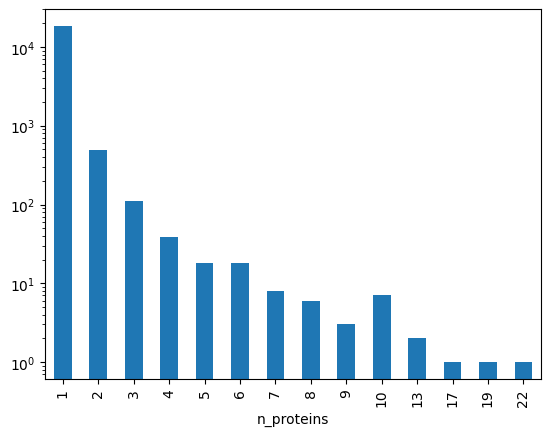

In [40]:
# create a df with clusters as entry
uniref_df = uniprot_id_mapping_df.groupby('External_ID')['UniProtKB_Accession'].apply(list).reset_index()
uniref_df.columns = ['UniRef50_Cluster', 'proteins']

# count
uniref_df["n_proteins"] = uniref_df.proteins.apply(len)
uniref_df.sort_values(by="n_proteins", inplace=True, ascending=False)

# plot
uniref_df.n_proteins.value_counts().sort_index().plot(kind="bar", logy=True)
uniref_df


In [44]:
# Maps proteisn names to gene names
        # ATTENTIon: mapping will have only human  curate genes
uniref_df["genes"] = uniref_df["proteins"].apply(
    lambda lst: [protein_to_gene_map.get(p, None) for p in lst]
)

# Add the 'label' column: 'positive' if at least one protein maps to a positive gene, otherwise 'negative'
uniref_df["cluster_label"] = uniref_df["genes"].apply(
    lambda gene_list: "positive" 
    if any(g in positive_genes for g in gene_list)
    else "negative"
)

# plost how many postive genesets
print(uniref_df["cluster_label"].value_counts())#.sort_index().plot(kind="bar", logy=True,)


uniref_df

cluster_label
negative    17831
positive     1328
Name: count, dtype: int64


,UniRef50_Cluster,proteins,n_proteins,genes,cluster_label
11185,UniRef50_Q86YD7,"[Q86YD7, Q658T7, A0A8V8TPE2, A8MXJ8, A6NKC0, A...",22,"[FAM90A1, FAM90A2P, FAM90A3 FAM90A3P, FAM90A5 ...",negative
9925,UniRef50_Q6R6M4,"[Q7RTZ2, Q6R6M4, A6NCW0, A6NCW7, A8MUK1, P0C7H...",19,"[USP17L1 USP17L USP17L1P, USP17L2 DUB3 USP17 U...",negative
7063,UniRef50_Q13066,"[A6NGK3, Q4V321, Q6NT46, Q13066, Q4V326, P0DTW...",17,"[GAGE10, GAGE13 GAGE12A, GAGE2A GAGE2, GAGE2B ...",positive
9177,UniRef50_Q5VXH4,"[O60813, O95522, P0DUQ1, Q5VT98, A6NGN4, H0Y7S...",13,"[PRAMEF11, PRAMEF12, PRAMEF15, PRAMEF20 PRAMEF...",positive
18902,UniRef50_Q9Y5E9,"[Q9Y5E7, Q9Y5E6, Q9Y5E5, Q9Y5E2, Q9UN66, Q9Y5E...",13,"[PCDHB2, PCDHB3, PCDHB4, PCDHB7, PCDHB8 PCDH3I...",negative
...,...,...,...,...,...
6588,UniRef50_Q02078,[Q02078],1,[MEF2A MEF2],negative
6587,UniRef50_Q02067,[P50553],1,[ASCL1 ASH1 BHLHA46 HASH1],negative
6586,UniRef50_Q02045,[Q02045],1,[MYL5],negative
6585,UniRef50_Q02040,[Q02040],1,[AKAP17A CXYorf3 DXYS155E SFRS17A XE7],negative


,UniRef50_Cluster,proteins,n_proteins,genes,cluster_label,proteins_positive,genes_positive,n_genes_positive
1929,UniRef50_O60811,"[O60809, Q5VWM6, Q5SWL7, Q5VTA0, Q5VWM3, Q5SWL...",10,"[PRAMEF10, PRAMEF13, PRAMEF14, PRAMEF17, PRAME...",positive,"[O60809, Q5VWM6, Q5SWL7, Q5VTA0, Q5VWM3, Q5SWL...","[PRAMEF10, PRAMEF13, PRAMEF14, PRAMEF17, PRAME...",10
9177,UniRef50_Q5VXH4,"[O60813, O95522, P0DUQ1, Q5VT98, A6NGN4, H0Y7S...",13,"[PRAMEF11, PRAMEF12, PRAMEF15, PRAMEF20 PRAMEF...",positive,"[O60813, O95522, P0DUQ1, A6NGN4, H0Y7S4, A3QJZ...","[PRAMEF11, PRAMEF12, PRAMEF15, PRAMEF25, PRAME...",10
16696,UniRef50_Q9HC98,"[Q9HC98, Q8TDX7]",2,"[NEK6, NEK7]",positive,"[Q9HC98, Q8TDX7]","[NEK6, NEK7]",2
9079,UniRef50_Q5TYM5,"[Q5TYM5, Q86X60, H0Y354, Q6L9T8]",4,"[FAM72A UGENE, FAM72B, FAM72C, FAM72D GCUD2]",positive,"[Q86X60, H0Y354]","[FAM72B, FAM72C]",2
16560,UniRef50_Q9H9S0,"[Q9H9S0, Q6NSW7]",2,"[NANOG, NANOGP8]",positive,"[Q9H9S0, Q6NSW7]","[NANOG, NANOGP8]",2


(19159, 8)

<Axes: xlabel='n_genes_positive'>

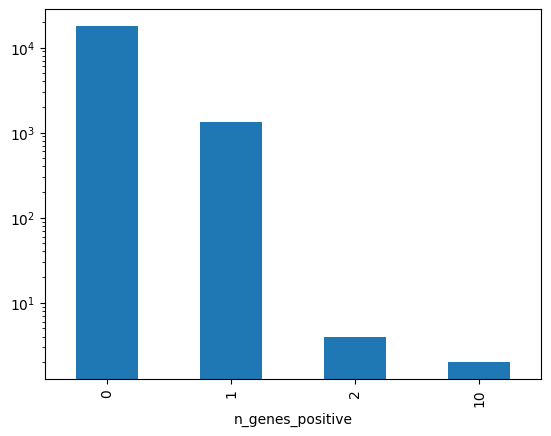

In [52]:
# create list of genes AND CORREPSONDET prots that are postive (from above)

# unzip in parallel pritens_clened and genes_clened and create ritens_clened_psotive and genes_clened_positive 
    # maintain if proteins comes form psotive gene
uniref_df["proteins_positive"], uniref_df["genes_positive"] = zip(*uniref_df.apply(
    lambda row: (
        [p for p, g in zip(row["proteins"], row["genes"]) if g in positive_genes],
        [g for g in row["genes"] if g in positive_genes]
    ),
    axis=1
))
uniref_df["n_genes_positive"] = uniref_df["genes_positive"].apply(len)
uniref_df.sort_values(by="n_genes_positive", ascending=False, inplace=True)

display(uniref_df.head(5))
display(uniref_df.shape)
uniref_df.n_genes_positive.value_counts().plot(kind="bar", logy=True)

In [54]:
# give probablities to be samped to each protein
uniref_df["logits"] = uniref_df["genes_positive"].apply(
    lambda gene_list: [positive_gene_freq_map.get(g, 0) for g in gene_list]
)
def safe_softmax(logits):
    if len(logits) == 0:
        return []  # return empty list if no logits
    return softmax(logits).tolist()  # convert numpy array to list
uniref_df["probs"] = uniref_df["logits"].apply(safe_softmax)

uniref_df

,UniRef50_Cluster,proteins,n_proteins,genes,cluster_label,proteins_positive,genes_positive,n_genes_positive,logits,probs
1929,UniRef50_O60811,"[O60809, Q5VWM6, Q5SWL7, Q5VTA0, Q5VWM3, Q5SWL...",10,"[PRAMEF10, PRAMEF13, PRAMEF14, PRAMEF17, PRAME...",positive,"[O60809, Q5VWM6, Q5SWL7, Q5VTA0, Q5VWM3, Q5SWL...","[PRAMEF10, PRAMEF13, PRAMEF14, PRAMEF17, PRAME...",10,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ..."
9177,UniRef50_Q5VXH4,"[O60813, O95522, P0DUQ1, Q5VT98, A6NGN4, H0Y7S...",13,"[PRAMEF11, PRAMEF12, PRAMEF15, PRAMEF20 PRAMEF...",positive,"[O60813, O95522, P0DUQ1, A6NGN4, H0Y7S4, A3QJZ...","[PRAMEF11, PRAMEF12, PRAMEF15, PRAMEF25, PRAME...",10,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ..."
16696,UniRef50_Q9HC98,"[Q9HC98, Q8TDX7]",2,"[NEK6, NEK7]",positive,"[Q9HC98, Q8TDX7]","[NEK6, NEK7]",2,"[19, 11]","[0.9996646498695336, 0.00033535013046647816]"
9079,UniRef50_Q5TYM5,"[Q5TYM5, Q86X60, H0Y354, Q6L9T8]",4,"[FAM72A UGENE, FAM72B, FAM72C, FAM72D GCUD2]",positive,"[Q86X60, H0Y354]","[FAM72B, FAM72C]",2,"[5, 3]","[0.8807970779778823, 0.11920292202211755]"
16560,UniRef50_Q9H9S0,"[Q9H9S0, Q6NSW7]",2,"[NANOG, NANOGP8]",positive,"[Q9H9S0, Q6NSW7]","[NANOG, NANOGP8]",2,"[6, 14]","[0.00033535013046647816, 0.9996646498695336]"
...,...,...,...,...,...,...,...,...,...,...
18678,UniRef50_Q9Y2U5,[Q9Y2U5],1,[MAP3K2 MAPKKK2 MEKK2],negative,[],[],0,[],[]
18679,UniRef50_Q9Y2U8,[Q9Y2U8],1,[LEMD3 MAN1],negative,[],[],0,[],[]
18680,UniRef50_Q9Y2U9,[Q9Y2U9],1,[KLHDC2 HCA33],negative,[],[],0,[],[]
18681,UniRef50_Q9Y2V0,[Q9Y2V0],1,[CDIN1 C15orf41],negative,[],[],0,[],[]


In [102]:
# Create list of putative negative genes/protein        
    # putatove = neither postive neither ambigous
gene_to_exclude = ambiguos_genes.union(positive_genes)

uniref_df["putative_negative_proteins"], uniref_df["putative_negative_genes"] = zip(*uniref_df.apply(
    lambda row: (
        [p for p, g in zip(row["proteins"], row["genes"]) if g not in gene_to_exclude],
        [g for g in row["genes"] if g not in gene_to_exclude]
    ),
    axis=1
))

uniref_df["n_putative_negative_genes"] = uniref_df.putative_negative_genes.apply(len)

display(uniref_df.tail(5))


,UniRef50_Cluster,proteins,n_proteins,genes,cluster_label,proteins_positive,genes_positive,n_genes_positive,logits,probs,putative_negative_proteins,putative_negative_genes,n_putative_negative_genes
18678,UniRef50_Q9Y2U5,[Q9Y2U5],1,[MAP3K2 MAPKKK2 MEKK2],negative,[],[],0,[],[],[Q9Y2U5],[MAP3K2 MAPKKK2 MEKK2],1
18679,UniRef50_Q9Y2U8,[Q9Y2U8],1,[LEMD3 MAN1],negative,[],[],0,[],[],[Q9Y2U8],[LEMD3 MAN1],1
18680,UniRef50_Q9Y2U9,[Q9Y2U9],1,[KLHDC2 HCA33],negative,[],[],0,[],[],[Q9Y2U9],[KLHDC2 HCA33],1
18681,UniRef50_Q9Y2V0,[Q9Y2V0],1,[CDIN1 C15orf41],negative,[],[],0,[],[],[Q9Y2V0],[CDIN1 C15orf41],1
18635,UniRef50_Q9Y2I9,[Q9Y2I9],1,[TBC1D30 KIAA0984],negative,[],[],0,[],[],[Q9Y2I9],[TBC1D30 KIAA0984],1


## Positive class sampling

For each postive class, take N posive proteins with prob defined above (ie prob based on MSigDB freq)

In [103]:
def sample_sampled_from_single_row(row, min_sample_n, prot_col, gene_col, probs_col):

    N = min(len(row[prot_col]), min_sample_n)

    if probs_col != None:
        probs = row[probs_col] #use precompued prbs
    else:
        probs=None # unirform prob

    # sample indices
    sampled_indices = np.random.choice(len(row[prot_col]), size=N, replace=False, p=probs) 

    # covert to array
    proteins_array = np.array(row[prot_col])
    genes_array = np.array(row[gene_col])

    # return sliced
    return proteins_array[sampled_indices], genes_array[sampled_indices]

In [114]:
# Filter only positive clusters
uniref_df_pos = uniref_df[uniref_df.cluster_label == "positive"].copy()

uniref_df_pos["proteins_sampled"], uniref_df_pos["genes_sampled"] = zip(
    *uniref_df_pos.apply(
            sample_sampled_from_single_row, 
            axis=1, 
            min_sample_n=MIN_SAMPLE_N_POSITIVE, 
            gene_col="genes_positive", 
            prot_col="proteins_positive", 
            probs_col="probs")
)
uniref_df_pos["n_proteins_sampled"] = uniref_df_pos.proteins_sampled.apply(len)

uniref_df_pos

,UniRef50_Cluster,proteins,n_proteins,genes,cluster_label,proteins_positive,genes_positive,n_genes_positive,logits,probs,putative_negative_proteins,putative_negative_genes,n_putative_negative_genes,proteins_sampled,genes_sampled,n_proteins_sampled
1929,UniRef50_O60811,"[O60809, Q5VWM6, Q5SWL7, Q5VTA0, Q5VWM3, Q5SWL...",10,"[PRAMEF10, PRAMEF13, PRAMEF14, PRAMEF17, PRAME...",positive,"[O60809, Q5VWM6, Q5SWL7, Q5VTA0, Q5VWM3, Q5SWL...","[PRAMEF10, PRAMEF13, PRAMEF14, PRAMEF17, PRAME...",10,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",[],[],0,"[O60809, A0A0G2JMD5]","[PRAMEF10, PRAMEF33]",2
9177,UniRef50_Q5VXH4,"[O60813, O95522, P0DUQ1, Q5VT98, A6NGN4, H0Y7S...",13,"[PRAMEF11, PRAMEF12, PRAMEF15, PRAMEF20 PRAMEF...",positive,"[O60813, O95522, P0DUQ1, A6NGN4, H0Y7S4, A3QJZ...","[PRAMEF11, PRAMEF12, PRAMEF15, PRAMEF25, PRAME...",10,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...","[Q5VT98, Q5TYX0, Q5VWM4]","[PRAMEF20 PRAMEF21, PRAMEF5 PRAMEF23 PRAMEF5L,...",3,"[H0Y7S4, P0DUQ1]","[PRAMEF26, PRAMEF15]",2
16696,UniRef50_Q9HC98,"[Q9HC98, Q8TDX7]",2,"[NEK6, NEK7]",positive,"[Q9HC98, Q8TDX7]","[NEK6, NEK7]",2,"[19, 11]","[0.9996646498695336, 0.00033535013046647816]",[],[],0,"[Q9HC98, Q8TDX7]","[NEK6, NEK7]",2
9079,UniRef50_Q5TYM5,"[Q5TYM5, Q86X60, H0Y354, Q6L9T8]",4,"[FAM72A UGENE, FAM72B, FAM72C, FAM72D GCUD2]",positive,"[Q86X60, H0Y354]","[FAM72B, FAM72C]",2,"[5, 3]","[0.8807970779778823, 0.11920292202211755]","[Q5TYM5, Q6L9T8]","[FAM72A UGENE, FAM72D GCUD2]",2,"[Q86X60, H0Y354]","[FAM72B, FAM72C]",2
16560,UniRef50_Q9H9S0,"[Q9H9S0, Q6NSW7]",2,"[NANOG, NANOGP8]",positive,"[Q9H9S0, Q6NSW7]","[NANOG, NANOGP8]",2,"[6, 14]","[0.00033535013046647816, 0.9996646498695336]",[],[],0,"[Q6NSW7, Q9H9S0]","[NANOGP8, NANOG]",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14613,UniRef50_Q96N38,"[Q96N38, P0DPD5]",2,"[ZNF714, ZNF723]",positive,[Q96N38],[ZNF714],1,[3],[1.0],[P0DPD5],[ZNF723],1,[Q96N38],[ZNF714],1
5514,UniRef50_P51141,"[O14640, P54792]",2,"[DVL1, DVL1P1 DVL DVL1 DVL1L1]",positive,[O14640],[DVL1],1,[2],[1.0],[P54792],[DVL1P1 DVL DVL1 DVL1L1],1,[O14640],[DVL1],1
1168,UniRef50_O09009,[Q9Y644],1,[RFNG],positive,[Q9Y644],[RFNG],1,[2],[1.0],[],[],0,[Q9Y644],[RFNG],1
3459,UniRef50_P0DMV8,"[P0DMV8, P0DMV9, P34931]",3,"[HSPA1A HSP72 HSPA1 HSX70, HSPA1B HSP72, HSPA1L]",positive,[P34931],[HSPA1L],1,[4],[1.0],"[P0DMV8, P0DMV9]","[HSPA1A HSP72 HSPA1 HSX70, HSPA1B HSP72]",2,[P34931],[HSPA1L],1


## Negative class sampling

1. Sample N samples from ALL cluster
    - so also the ones that contains positive proteins
    - Be sure to remove from the pool that we are allowed to sample
        - Positive proteins
        - Ambiguous protein

2. After this sampling you will have (done LATER in notebook)
    - | pos prot | << | neg prot | → more thna 1:3 ration
    - Need to subsampled negative class
    - Subsample negative class
        - Retain all proteins that comes form clusters that have a positive protein
        - Subsample the remaining cluster to have a final ratio 1:3

In [ ]:
# Filter only positive clusters
    # sample from all clsuter
    # but they shiudl have at least 1 neagtive protein
uniref_df_neg = uniref_df[uniref_df.n_putative_negative_genes > 0].copy() 

uniref_df_neg["proteins_sampled"], uniref_df_neg["genes_sampled"] = zip(
    *uniref_df_neg.apply(
            sample_sampled_from_single_row, 
            axis=1, 
            min_sample_n=MIN_SAMPLE_N_POSITIVE, 
            gene_col="putative_negative_genes", 
            prot_col="putative_negative_proteins", 
            probs_col=None # uniform
            )
)
uniref_df_neg["n_proteins_sampled"] = uniref_df_neg.proteins_sampled.apply(len)

# ATTENTION: same clusters coudl have 0 proteins to sample from (all proteins are postive OR ambigous so nothing left to sample as negative)
uniref_df_neg = uniref_df_neg[uniref_df_neg.n_proteins_sampled > 0]

uniref_df_neg.head()

,UniRef50_Cluster,proteins,n_proteins,genes,cluster_label,proteins_positive,genes_positive,n_genes_positive,logits,probs,putative_negative_proteins,putative_negative_genes,n_putative_negative_genes,proteins_sampled,genes_sampled,n_proteins_sampled
9177,UniRef50_Q5VXH4,"[O60813, O95522, P0DUQ1, Q5VT98, A6NGN4, H0Y7S...",13,"[PRAMEF11, PRAMEF12, PRAMEF15, PRAMEF20 PRAMEF...",positive,"[O60813, O95522, P0DUQ1, A6NGN4, H0Y7S4, A3QJZ...","[PRAMEF11, PRAMEF12, PRAMEF15, PRAMEF25, PRAME...",10,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...","[Q5VT98, Q5TYX0, Q5VWM4]","[PRAMEF20 PRAMEF21, PRAMEF5 PRAMEF23 PRAMEF5L,...",3,"[Q5VT98, Q5TYX0]","[PRAMEF20 PRAMEF21, PRAMEF5 PRAMEF23 PRAMEF5L]",2
9079,UniRef50_Q5TYM5,"[Q5TYM5, Q86X60, H0Y354, Q6L9T8]",4,"[FAM72A UGENE, FAM72B, FAM72C, FAM72D GCUD2]",positive,"[Q86X60, H0Y354]","[FAM72B, FAM72C]",2,"[5, 3]","[0.8807970779778823, 0.11920292202211755]","[Q5TYM5, Q6L9T8]","[FAM72A UGENE, FAM72D GCUD2]",2,"[Q6L9T8, Q5TYM5]","[FAM72D GCUD2, FAM72A UGENE]",2
3482,UniRef50_P0DP91,"[P0DP91, Q8N328]",2,"[ERCC6, PGBD3]",positive,[P0DP91],[ERCC6],1,[10],[1.0],[Q8N328],[PGBD3],1,[Q8N328],[PGBD3],1
3494,UniRef50_P0DPH7,"[P0DPH7, P0DPH8]",2,"[TUBA3C TUBA2, TUBA3D]",positive,[P0DPH8],[TUBA3D],1,[9],[1.0],[P0DPH7],[TUBA3C TUBA2],1,[P0DPH7],[TUBA3C TUBA2],1
16592,UniRef50_Q9HAT0,"[Q9HAT0, Q9BZX4]",2,"[ROPN1 ROPN1A, ROPN1B]",positive,[Q9BZX4],[ROPN1B],1,[2],[1.0],[Q9HAT0],[ROPN1 ROPN1A],1,[Q9HAT0],[ROPN1 ROPN1A],1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18678,UniRef50_Q9Y2U5,[Q9Y2U5],1,[MAP3K2 MAPKKK2 MEKK2],negative,[],[],0,[],[],[Q9Y2U5],[MAP3K2 MAPKKK2 MEKK2],1,[Q9Y2U5],[MAP3K2 MAPKKK2 MEKK2],1
18679,UniRef50_Q9Y2U8,[Q9Y2U8],1,[LEMD3 MAN1],negative,[],[],0,[],[],[Q9Y2U8],[LEMD3 MAN1],1,[Q9Y2U8],[LEMD3 MAN1],1
18680,UniRef50_Q9Y2U9,[Q9Y2U9],1,[KLHDC2 HCA33],negative,[],[],0,[],[],[Q9Y2U9],[KLHDC2 HCA33],1,[Q9Y2U9],[KLHDC2 HCA33],1
18681,UniRef50_Q9Y2V0,[Q9Y2V0],1,[CDIN1 C15orf41],negative,[],[],0,[],[],[Q9Y2V0],[CDIN1 C15orf41],1,[Q9Y2V0],[CDIN1 C15orf41],1


## Make dataset

Final df shoudl be:
- | Cluster | protein name | label | seq |

In [ ]:
# add labels
uniref_df_pos["label_single_prot"] = 1
uniref_df_neg["label_single_prot"] = 0

# merge --> each entry is a cluster
dataset_df = pd.concat([uniref_df_pos, uniref_df_neg])
display(dataset_df.head())


,UniRef50_Cluster,proteins,n_proteins,genes,cluster_label,proteins_positive,genes_positive,n_genes_positive,logits,probs,putative_negative_proteins,putative_negative_genes,n_putative_negative_genes,proteins_sampled,genes_sampled,n_proteins_sampled,label_single_prot
1929,UniRef50_O60811,"[O60809, Q5VWM6, Q5SWL7, Q5VTA0, Q5VWM3, Q5SWL...",10,"[PRAMEF10, PRAMEF13, PRAMEF14, PRAMEF17, PRAME...",positive,"[O60809, Q5VWM6, Q5SWL7, Q5VTA0, Q5VWM3, Q5SWL...","[PRAMEF10, PRAMEF13, PRAMEF14, PRAMEF17, PRAME...",10,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",[],[],0,"[O60809, A0A0G2JMD5]","[PRAMEF10, PRAMEF33]",2,1
9177,UniRef50_Q5VXH4,"[O60813, O95522, P0DUQ1, Q5VT98, A6NGN4, H0Y7S...",13,"[PRAMEF11, PRAMEF12, PRAMEF15, PRAMEF20 PRAMEF...",positive,"[O60813, O95522, P0DUQ1, A6NGN4, H0Y7S4, A3QJZ...","[PRAMEF11, PRAMEF12, PRAMEF15, PRAMEF25, PRAME...",10,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...","[Q5VT98, Q5TYX0, Q5VWM4]","[PRAMEF20 PRAMEF21, PRAMEF5 PRAMEF23 PRAMEF5L,...",3,"[H0Y7S4, P0DUQ1]","[PRAMEF26, PRAMEF15]",2,1
16696,UniRef50_Q9HC98,"[Q9HC98, Q8TDX7]",2,"[NEK6, NEK7]",positive,"[Q9HC98, Q8TDX7]","[NEK6, NEK7]",2,"[19, 11]","[0.9996646498695336, 0.00033535013046647816]",[],[],0,"[Q9HC98, Q8TDX7]","[NEK6, NEK7]",2,1
9079,UniRef50_Q5TYM5,"[Q5TYM5, Q86X60, H0Y354, Q6L9T8]",4,"[FAM72A UGENE, FAM72B, FAM72C, FAM72D GCUD2]",positive,"[Q86X60, H0Y354]","[FAM72B, FAM72C]",2,"[5, 3]","[0.8807970779778823, 0.11920292202211755]","[Q5TYM5, Q6L9T8]","[FAM72A UGENE, FAM72D GCUD2]",2,"[Q86X60, H0Y354]","[FAM72B, FAM72C]",2,1
16560,UniRef50_Q9H9S0,"[Q9H9S0, Q6NSW7]",2,"[NANOG, NANOGP8]",positive,"[Q9H9S0, Q6NSW7]","[NANOG, NANOGP8]",2,"[6, 14]","[0.00033535013046647816, 0.9996646498695336]",[],[],0,"[Q6NSW7, Q9H9S0]","[NANOGP8, NANOG]",2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18678,UniRef50_Q9Y2U5,[Q9Y2U5],1,[MAP3K2 MAPKKK2 MEKK2],negative,[],[],0,[],[],[Q9Y2U5],[MAP3K2 MAPKKK2 MEKK2],1,[Q9Y2U5],[MAP3K2 MAPKKK2 MEKK2],1,0
18679,UniRef50_Q9Y2U8,[Q9Y2U8],1,[LEMD3 MAN1],negative,[],[],0,[],[],[Q9Y2U8],[LEMD3 MAN1],1,[Q9Y2U8],[LEMD3 MAN1],1,0
18680,UniRef50_Q9Y2U9,[Q9Y2U9],1,[KLHDC2 HCA33],negative,[],[],0,[],[],[Q9Y2U9],[KLHDC2 HCA33],1,[Q9Y2U9],[KLHDC2 HCA33],1,0
18681,UniRef50_Q9Y2V0,[Q9Y2V0],1,[CDIN1 C15orf41],negative,[],[],0,[],[],[Q9Y2V0],[CDIN1 C15orf41],1,[Q9Y2V0],[CDIN1 C15orf41],1,0


In [135]:
# smaller df
cols_to_keep = ['UniRef50_Cluster', 'proteins_sampled',
                'genes_sampled', 'label_single_prot']
dataset_df_small = dataset_df[cols_to_keep].copy()

display(dataset_df_small)
print("ATTENTION: the number of proteins sampled is less than the total ~20000 of Swissport, as we subsampled only N, so we may have lsot some proteins")
print(len(set(gene for sublist in dataset_df_small['proteins_sampled'] for gene in sublist)), "/ 20000")

# Create a new DataFrame where each row corresponds to a (protein, gene) pair
rows = []
for _, row in dataset_df_small.iterrows():
    cluster = row["UniRef50_Cluster"]
    label = row["label_single_prot"]
    proteins = row["proteins_sampled"]
    genes = row["genes_sampled"]

    # zip ensures 1-to-1 pairing between proteins and genes
    for prot, gene in zip(proteins, genes):
        rows.append({
            "UniRef50_Cluster": cluster,
            "protein": prot,
            "gene": gene,
            "label": label
        })

df_long = pd.DataFrame(rows)

# checj fro duplcates
print("\nDuplicated rows/proteins: ", df_long.shape[0] - df_long.protein.nunique())

df_long

,UniRef50_Cluster,proteins_sampled,genes_sampled,label_single_prot
1929,UniRef50_O60811,"[O60809, A0A0G2JMD5]","[PRAMEF10, PRAMEF33]",1
9177,UniRef50_Q5VXH4,"[H0Y7S4, P0DUQ1]","[PRAMEF26, PRAMEF15]",1
16696,UniRef50_Q9HC98,"[Q9HC98, Q8TDX7]","[NEK6, NEK7]",1
9079,UniRef50_Q5TYM5,"[Q86X60, H0Y354]","[FAM72B, FAM72C]",1
16560,UniRef50_Q9H9S0,"[Q6NSW7, Q9H9S0]","[NANOGP8, NANOG]",1
...,...,...,...,...
18678,UniRef50_Q9Y2U5,[Q9Y2U5],[MAP3K2 MAPKKK2 MEKK2],0
18679,UniRef50_Q9Y2U8,[Q9Y2U8],[LEMD3 MAN1],0
18680,UniRef50_Q9Y2U9,[Q9Y2U9],[KLHDC2 HCA33],0
18681,UniRef50_Q9Y2V0,[Q9Y2V0],[CDIN1 C15orf41],0


ATTENTION: the number of proteins sampled is less than the total ~20000 of Swissport, as we subsampled only N, so we may have lsot some proteins
18931 / 20000

Duplicated rows/proteins:  0


,UniRef50_Cluster,protein,gene,label
0,UniRef50_O60811,O60809,PRAMEF10,1
1,UniRef50_O60811,A0A0G2JMD5,PRAMEF33,1
2,UniRef50_Q5VXH4,H0Y7S4,PRAMEF26,1
3,UniRef50_Q5VXH4,P0DUQ1,PRAMEF15,1
4,UniRef50_Q9HC98,Q9HC98,NEK6,1
...,...,...,...,...
18926,UniRef50_Q9Y2U5,Q9Y2U5,MAP3K2 MAPKKK2 MEKK2,0
18927,UniRef50_Q9Y2U8,Q9Y2U8,LEMD3 MAN1,0
18928,UniRef50_Q9Y2U9,Q9Y2U9,KLHDC2 HCA33,0
18929,UniRef50_Q9Y2V0,Q9Y2V0,CDIN1 C15orf41,0


# Assure 1:3 ratio in postive and negative class
After this sampling you will have (done LATER in notebook)
- | pos prot | << | neg prot | → more thna 1:3 ration
- Need to subsampled negative class
- Subsample negative class
    - Retain all proteins that comes form clusters that have a positive protein
    - Subsample the remaining cluster to have a final ratio 1:3

In [151]:
# list of smpled positve proteins
positive_proteins_tmp = set(df_long[df_long.label == 1]["protein"].unique())

# list of prtein in MIXED cluster (wiht inside btoh postive and negative prteins)
proteins_in_mixed_clusters = df_long.groupby('UniRef50_Cluster').filter(lambda x: x['label'].nunique() > 1).sort_values(by="UniRef50_Cluster")
proteins_in_mixed_clusters = set(proteins_in_mixed_clusters["protein"].unique())

# proteins to NOT remove
proteins_not_to_remove = proteins_in_mixed_clusters.union(positive_proteins_tmp)

# give col
df_long["can_be_removed"] = ~df_long["protein"].isin(proteins_not_to_remove)

df_long

,UniRef50_Cluster,protein,gene,label,can_be_removed
0,UniRef50_O60811,O60809,PRAMEF10,1,False
1,UniRef50_O60811,A0A0G2JMD5,PRAMEF33,1,False
2,UniRef50_Q5VXH4,H0Y7S4,PRAMEF26,1,False
3,UniRef50_Q5VXH4,P0DUQ1,PRAMEF15,1,False
4,UniRef50_Q9HC98,Q9HC98,NEK6,1,False
...,...,...,...,...,...
18926,UniRef50_Q9Y2U5,Q9Y2U5,MAP3K2 MAPKKK2 MEKK2,0,True
18927,UniRef50_Q9Y2U8,Q9Y2U8,LEMD3 MAN1,0,True
18928,UniRef50_Q9Y2U9,Q9Y2U9,KLHDC2 HCA33,0,True
18929,UniRef50_Q9Y2V0,Q9Y2V0,CDIN1 C15orf41,0,True


In [152]:
# decide fraction to susample

# Number of positive proteins
n_positive = df_long[df_long["label"] == 1].shape[0]
# Number desidered negative
n_desired_negatives = n_positive * NEGATIVE_CLASS_MULT
# Removable (negative) proteins
removable_negatives = df_long[(df_long["label"] == 0) & (df_long["can_be_removed"])]
# Determine fraction to subsample
frac_to_sample = n_desired_negatives / len(removable_negatives)
frac_to_sample = min(frac_to_sample, 1.0)  # cannot sample more than available

frac_to_sample

0.228021195373483

In [161]:

# susample
removable = df_long[df_long["can_be_removed"]]
keep = df_long[~df_long["can_be_removed"]]

subsampled_removable = removable.sample(frac=frac_to_sample, random_state=SEED)

df_subsampled = pd.concat([keep, subsampled_removable]).reset_index(drop=True) # Combine back with the protected proteins

print(df_subsampled.label.value_counts())
df_subsampled

label
0    4048
1    1334
Name: count, dtype: int64


,UniRef50_Cluster,protein,gene,label,can_be_removed
0,UniRef50_O60811,O60809,PRAMEF10,1,False
1,UniRef50_O60811,A0A0G2JMD5,PRAMEF33,1,False
2,UniRef50_Q5VXH4,H0Y7S4,PRAMEF26,1,False
3,UniRef50_Q5VXH4,P0DUQ1,PRAMEF15,1,False
4,UniRef50_Q9HC98,Q9HC98,NEK6,1,False
...,...,...,...,...,...
5377,UniRef50_Q99550,Q99550,MPHOSPH9 MPP9,0,True
5378,UniRef50_P09067,P09067,HOXB5 HOX2A,0,True
5379,UniRef50_P07332,P07332,FES FPS,0,True
5380,UniRef50_Q8IX29,Q8IX29,FBXO16 FBX16,0,True


## Give Seq


In [162]:
### create df to join
join_df_tmp = proteome_uniprot[["Entry", "Sequence"]].copy().rename(columns={"Sequence": "sequence"})

# join
    # ATTNETION: we shoudl NOT lose any col
long_df_seq = pd.merge(how="inner", left=df_subsampled, right=join_df_tmp, left_on="protein", right_on="Entry")

# drp cols
long_df_seq.drop(columns=["can_be_removed", "Entry"], inplace=True)

long_df_seq

,UniRef50_Cluster,protein,gene,label,sequence
0,UniRef50_O60811,O60809,PRAMEF10,1,MSLQAPSRLLELAGQSLLRNQFLTIFTLDELPREVFPLMFMEAFSM...
1,UniRef50_O60811,A0A0G2JMD5,PRAMEF33,1,MSLQAPSRLLELAGQSLLRNQFLTIFTLDELPREVFPLMFMEAFSM...
2,UniRef50_Q5VXH4,H0Y7S4,PRAMEF26,1,MKMSIRTPPRLLELAGRSVLRDQALAMSTLEELPTELFPPLFMEAF...
3,UniRef50_Q5VXH4,P0DUQ1,PRAMEF15,1,MKMSIRTPPRLLELAGRSLLRDQALAMSTLEELPTELFPPLFMEAF...
4,UniRef50_Q9HC98,Q9HC98,NEK6,1,MAGQPGHMPHGGSSNNLCHTLGPVHPPDPQRHPNTLSFRCSLADFQ...
...,...,...,...,...,...
5377,UniRef50_Q99550,Q99550,MPHOSPH9 MPP9,0,MEEFDLVKTLHKTSSSVGSDENSLHSLGLNLNTDRSSPHLSTNGVS...
5378,UniRef50_P09067,P09067,HOXB5 HOX2A,0,MSSYFVNSFSGRYPNGPDYQLLNYGSGSSLSGSYRDPAAMHTGSYG...
5379,UniRef50_P07332,P07332,FES FPS,0,MGFSSELCSPQGHGVLQQMQEAELRLLEGMRKWMAQRVKSDREYAG...
5380,UniRef50_Q8IX29,Q8IX29,FBXO16 FBX16,0,MMAFAPPKNTDGPKMQTKMSTWTPLNHQLLNDRVFEERRALLGKWF...


## Stratify dataset

We can stratify based on many metrics:
1. labels
2. PREVALENT metric
3. based on cluster
    - Put proteins coming from same cluster in different sets or not

In [168]:
# STRATIFIED spit
# Stratified split: 80% train, 10% val, 10% test
# First split: 80% train, 20% temp
train_idx, temp_idx = train_test_split(
    long_df_seq.index,
    test_size=0.2,
    stratify=long_df_seq['label'],
    random_state=42
)

# Second split: temp into val and test (50%-50% of temp)
temp_labels = long_df_seq.loc[temp_idx, 'label']
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,
    stratify=temp_labels,
    random_state=42
)

# Assign splits
long_df_seq['set'] = ''
long_df_seq.loc[train_idx, 'set'] = 'train'
long_df_seq.loc[val_idx, 'set'] = 'val'
long_df_seq.loc[test_idx, 'set'] = 'test'

print(long_df_seq.groupby('set')['label'].value_counts().unstack(fill_value=0))
display(long_df_seq)

label     0     1
set              
test    405   134
train  3238  1067
val     405   133


,UniRef50_Cluster,protein,gene,label,sequence,set
0,UniRef50_O60811,O60809,PRAMEF10,1,MSLQAPSRLLELAGQSLLRNQFLTIFTLDELPREVFPLMFMEAFSM...,train
1,UniRef50_O60811,A0A0G2JMD5,PRAMEF33,1,MSLQAPSRLLELAGQSLLRNQFLTIFTLDELPREVFPLMFMEAFSM...,train
2,UniRef50_Q5VXH4,H0Y7S4,PRAMEF26,1,MKMSIRTPPRLLELAGRSVLRDQALAMSTLEELPTELFPPLFMEAF...,train
3,UniRef50_Q5VXH4,P0DUQ1,PRAMEF15,1,MKMSIRTPPRLLELAGRSLLRDQALAMSTLEELPTELFPPLFMEAF...,train
4,UniRef50_Q9HC98,Q9HC98,NEK6,1,MAGQPGHMPHGGSSNNLCHTLGPVHPPDPQRHPNTLSFRCSLADFQ...,train
...,...,...,...,...,...,...
5377,UniRef50_Q99550,Q99550,MPHOSPH9 MPP9,0,MEEFDLVKTLHKTSSSVGSDENSLHSLGLNLNTDRSSPHLSTNGVS...,train
5378,UniRef50_P09067,P09067,HOXB5 HOX2A,0,MSSYFVNSFSGRYPNGPDYQLLNYGSGSSLSGSYRDPAAMHTGSYG...,train
5379,UniRef50_P07332,P07332,FES FPS,0,MGFSSELCSPQGHGVLQQMQEAELRLLEGMRKWMAQRVKSDREYAG...,train
5380,UniRef50_Q8IX29,Q8IX29,FBXO16 FBX16,0,MMAFAPPKNTDGPKMQTKMSTWTPLNHQLLNDRVFEERRALLGKWF...,train


# Optional: add precomputed protein embs

In [163]:
# TODO

## Save

In [169]:
long_df_seq.to_csv(FINAL_DATASET_PATH)